In [1]:
# import libraries

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition
from sklearn.metrics import confusion_matrix, cohen_kappa_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score


RSEED=42



In [3]:
# read data
df=pd.read_csv('../../data/data_with_target.csv')

In [6]:
# Define the audio features that you want to run PCA on!
mfcc = [col for col in df.columns if col.startswith('mfcc_mean')] 
chroma = [col for col in df.columns if col.startswith('chroma')]
rmse = [col for col in df.columns if col.startswith('rmse')]
zcr = [col for col in df.columns if col.startswith('zcr')]
spectral = [col for col in df.columns if col.startswith('spectral')]
tonnetz = [col for col in df.columns if col.startswith('tonnetz')]

# Define X, also possible to put more audio features in. For demo I only include mfcc features that undergo PCA (mfcc_mean)
X = df[['track_id', 'track_genre_top','track_bit_rate','track_duration','album_information_bin']+mfcc] #+chroma+rmse+zcr+spectral+tonnetz]
y = df['listens_bins']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")



We have 8000 observations in our dataset and 25 features
Our target vector has also 8000 values


In [7]:
# Creating list for categorical predictors/features 

cat_features = list(X.columns[X.dtypes==object])
cat_features

['track_genre_top']

In [8]:
# Creating list for numerical predictors/features

num_features = list(X.columns[X.dtypes!=object])
num_features

['track_id',
 'track_bit_rate',
 'track_duration',
 'album_information_bin',
 'mfcc_mean_01',
 'mfcc_mean_02',
 'mfcc_mean_03',
 'mfcc_mean_04',
 'mfcc_mean_05',
 'mfcc_mean_06',
 'mfcc_mean_07',
 'mfcc_mean_08',
 'mfcc_mean_09',
 'mfcc_mean_10',
 'mfcc_mean_11',
 'mfcc_mean_12',
 'mfcc_mean_13',
 'mfcc_mean_14',
 'mfcc_mean_15',
 'mfcc_mean_16',
 'mfcc_mean_17',
 'mfcc_mean_18',
 'mfcc_mean_19',
 'mfcc_mean_20']

In [9]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

#### Some optional vis

In [10]:
#Filter df to only have tracks that are in listens_bins
filtered_df = df[df['listens_bins'].isin([1,2,3,4,5])]
filtered_listens_bins = filtered_df['listens_bins'].to_numpy()


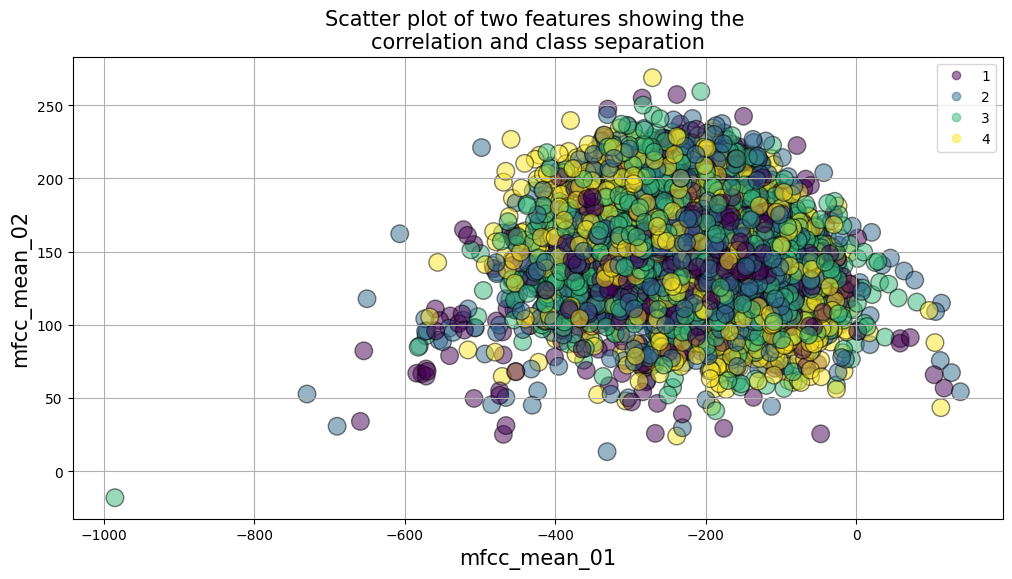

In [11]:
plt.figure(figsize=(12,6))
scatter = plt.scatter(filtered_df['mfcc_mean_01'],filtered_df['mfcc_mean_02'],c=filtered_listens_bins,edgecolors='k',alpha=0.5,s=160)
plt.grid(True)
classes = ['1','2','3','4', '5']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("Scatter plot of two features showing the \ncorrelation and class separation",fontsize=15)
plt.xlabel("mfcc_mean_01",fontsize=15)
plt.ylabel("mfcc_mean_02",fontsize=15)
plt.show()

## PCA on defined audio features

### Scaling of X_train and X_test

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
# Scale all mfcc features
X_train_mfcc_scaled = scaler.fit_transform(X_train[mfcc]) #replace in case you want PCA on other audio features
X_test_mfcc_scaled = scaler.transform(X_test[mfcc]) #replace in case you want PCA on other audio features


In [14]:
df_train_mfcc_scaled = pd.DataFrame(data=X_train_mfcc_scaled,columns=df[mfcc].columns[0:])
df_test_mfcc_scaled = pd.DataFrame(data=X_test_mfcc_scaled,columns=df[mfcc].columns[0:])

### PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=None)

In [17]:
df_train_mfcc_scaled_pca = pca.fit(df_train_mfcc_scaled)
df_test_mfcc_scaled_pca = pca.fit(df_test_mfcc_scaled)

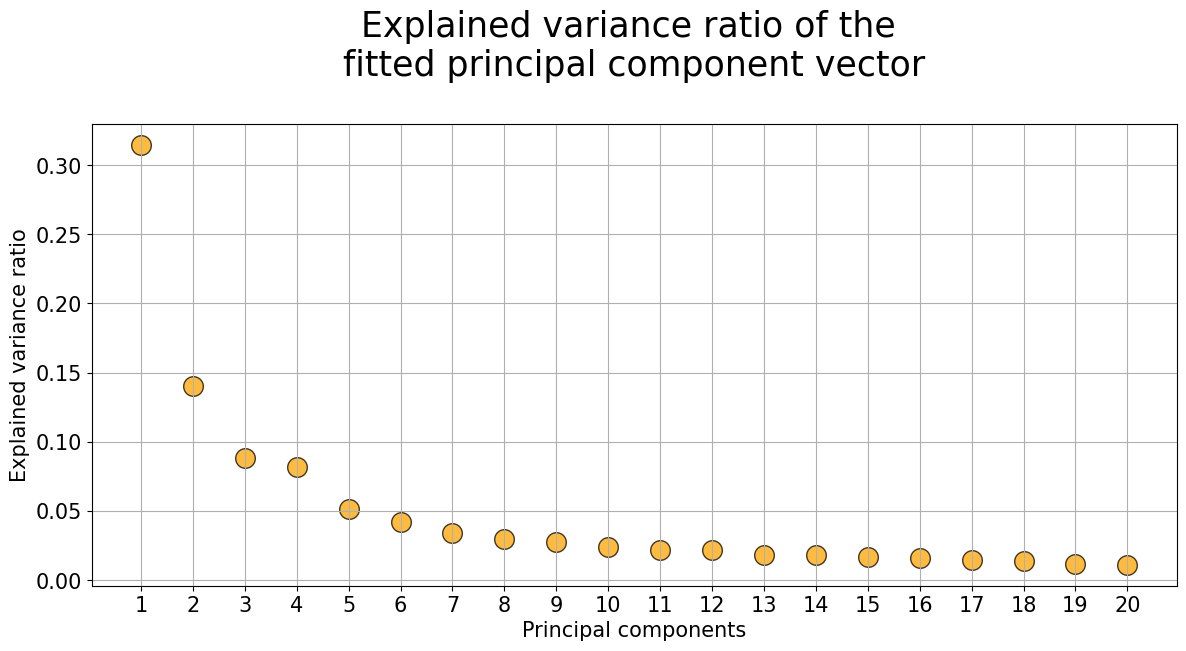

In [18]:
plt.figure(figsize=(14,6))
plt.scatter(x=[i+1 for i in range(len(df_train_mfcc_scaled_pca.explained_variance_ratio_))],
            y=df_train_mfcc_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_train_mfcc_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

#### Transform the scaled data set using the fitted PCA object

In [19]:
X_train_mfcc_scaled_trans = pca.transform(df_train_mfcc_scaled)
X_test_mfcc_scaled_trans = pca.transform(df_test_mfcc_scaled)

In [20]:
# Create DF with PC's as columns. Select only first 4 PC's
X_train_mfcc_scaled_trans = pd.DataFrame(data=X_train_mfcc_scaled_trans)
X_test_mfcc_scaled_trans = pd.DataFrame(data=X_test_mfcc_scaled_trans)

In [21]:
# Take out the first x components, in my example I took 5 components
X_train_mfcc_scaled_trans_5_pca = X_train_mfcc_scaled_trans.iloc[:, [0, 1, 2, 3, 4]]
# Rename columns to 1-4
X_train_mfcc_scaled_trans_5_pca.columns = X_train_mfcc_scaled_trans_5_pca.columns + 1

# Repeat for X_test
X_test_mfcc_scaled_trans_5_pca = X_test_mfcc_scaled_trans.iloc[:, [0, 1, 2, 3, 4]]
# Rename columns to 1-4
X_test_mfcc_scaled_trans_5_pca.columns = X_test_mfcc_scaled_trans_5_pca.columns + 1

In [22]:
# Add audio feature prefix to principal component columns. MFCC in this example
X_train_mfcc_scaled_trans_5_pca = X_train_mfcc_scaled_trans_5_pca.add_prefix('mfcc_pc_')
X_test_mfcc_scaled_trans_5_pca = X_test_mfcc_scaled_trans_5_pca.add_prefix('mfcc_pc_')

In [23]:
X_test_mfcc_scaled_trans_5_pca

,mfcc_pc_1,mfcc_pc_2,mfcc_pc_3,mfcc_pc_4,mfcc_pc_5
0,6.195253,0.001108,2.176676,0.793498,-0.698844
1,-0.627916,1.244282,1.382277,-0.331115,0.092507
2,-1.161724,-1.670688,1.834798,-1.306935,-0.207561
3,-2.408491,0.187297,-0.081593,0.406402,-0.067961
4,0.510665,-0.625929,-1.071900,0.828636,-0.017436
...,...,...,...,...,...
1595,-2.055630,-0.445517,-0.073156,1.828636,-0.478793
1596,-0.898687,-1.998242,-0.815059,-0.687938,-0.460727
1597,0.373943,-3.541890,0.352136,-0.037391,-0.901438
1598,-2.018875,0.669623,-0.374866,0.464457,0.135987


In [24]:
X_train_pca = X_train.drop(mfcc, axis=1)
X_test_pca = X_test.drop(mfcc, axis=1)

In [25]:
# Merge to final X_train and X_test with PCA applied to MFCCs

X_train_pca = pd.concat([X_train_pca.reset_index(drop=True),
               X_train_mfcc_scaled_trans_5_pca.reset_index(drop=True)], axis=1)

X_test_pca = pd.concat([X_test_pca.reset_index(drop=True),
               X_test_mfcc_scaled_trans_5_pca.reset_index(drop=True)], axis=1)

#### Transform categorical column in X_train, X_test

In [26]:
encoded_categories = pd.get_dummies(X_train['track_genre_top'], drop_first=True)
X_train = pd.concat([X_train, encoded_categories], axis=1)
X_train.drop('track_genre_top', axis=1, inplace=True)
X_train.head()

,track_id,track_bit_rate,track_duration,album_information_bin,mfcc_mean_01,mfcc_mean_02,mfcc_mean_03,mfcc_mean_04,mfcc_mean_05,mfcc_mean_06,...,mfcc_mean_18,mfcc_mean_19,mfcc_mean_20,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
1467,38779,314143,190,1,-205.642487,166.896393,-30.916273,41.261295,-3.828683,10.091277,...,-7.329958,-5.196857,-4.227788,False,False,False,False,True,False,False
5768,119941,188362,235,0,-123.754265,108.555046,-28.090488,36.149250,-5.320136,35.550655,...,5.460629,0.144956,1.885880,False,False,True,False,False,False,False
5714,118958,256000,123,1,-159.073303,166.846436,-55.223743,18.692921,-14.484131,1.691029,...,-1.648500,2.395553,-1.279103,True,False,False,False,False,False,False
1578,40239,256000,358,1,-161.913956,200.839813,-20.658346,30.287107,-8.804000,8.086582,...,7.037495,-3.094839,3.580608,False,True,False,False,False,False,False
6958,133272,320000,421,0,-132.533844,148.966873,-20.782124,43.705517,-1.520490,20.375437,...,-2.738687,0.416695,-1.831213,False,False,False,False,False,False,True


In [27]:
encoded_categories = pd.get_dummies(X_test['track_genre_top'], drop_first=True)
X_test = pd.concat([X_test, encoded_categories], axis=1)
X_test.drop('track_genre_top', axis=1, inplace=True)
X_test.head()

,track_id,track_bit_rate,track_duration,album_information_bin,mfcc_mean_01,mfcc_mean_02,mfcc_mean_03,mfcc_mean_04,mfcc_mean_05,mfcc_mean_06,...,mfcc_mean_18,mfcc_mean_19,mfcc_mean_20,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
2215,54033,320000,209,1,-290.082428,200.535461,19.422188,-1.940620,3.383878,-16.619696,...,-9.054040,-4.478038,-1.633834,False,False,False,False,False,True,False
2582,59876,256000,275,1,-150.451843,158.949203,-19.133646,32.760956,-11.229121,13.938159,...,2.439164,0.702295,0.705506,False,False,False,False,False,False,True
1662,42234,256000,255,1,-184.016998,198.575760,-26.719437,28.452091,3.108793,7.331948,...,1.671023,0.814980,-0.163836,False,False,False,False,True,False,False
3027,68893,320000,265,1,-141.127960,148.625748,22.967676,48.746201,-8.540991,15.336551,...,4.152239,0.610030,1.676256,False,False,False,False,False,False,False
4343,97544,228446,494,1,-236.987366,145.933136,22.222036,33.630787,4.442848,14.150504,...,-2.076400,-3.331032,-2.387396,False,False,False,False,False,False,False


#### Transform categorical column in X_train_pca and X_test_pca

In [28]:
encoded_categories = pd.get_dummies(X_train_pca['track_genre_top'], drop_first=True)
X_train_pca = pd.concat([X_train_pca, encoded_categories], axis=1)
X_train_pca.drop('track_genre_top', axis=1, inplace=True)
X_train_pca.head()

,track_id,track_bit_rate,track_duration,album_information_bin,mfcc_pc_1,mfcc_pc_2,mfcc_pc_3,mfcc_pc_4,mfcc_pc_5,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
0,38779,314143,190,1,2.923176,0.017076,-1.182548,-1.446064,-0.047355,False,False,False,False,True,False,False
1,119941,188362,235,0,-4.273512,1.621075,-0.140950,0.469070,-0.175643,False,False,True,False,False,False,False
2,118958,256000,123,1,1.736033,1.257350,3.271573,-1.478382,0.887866,True,False,False,False,False,False,False
3,40239,256000,358,1,-0.009457,-1.338636,0.757540,-1.338244,-0.387698,False,True,False,False,False,False,False
4,133272,320000,421,0,0.021436,0.030538,-1.399543,-0.785975,0.180570,False,False,False,False,False,False,True


In [29]:
encoded_categories = pd.get_dummies(X_test_pca['track_genre_top'], drop_first=True)
X_test_pca = pd.concat([X_test_pca, encoded_categories], axis=1)
X_test_pca.drop('track_genre_top', axis=1, inplace=True)
X_test_pca.head()

,track_id,track_bit_rate,track_duration,album_information_bin,mfcc_pc_1,mfcc_pc_2,mfcc_pc_3,mfcc_pc_4,mfcc_pc_5,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
0,54033,320000,209,1,6.195253,0.001108,2.176676,0.793498,-0.698844,False,False,False,False,False,True,False
1,59876,256000,275,1,-0.627916,1.244282,1.382277,-0.331115,0.092507,False,False,False,False,False,False,True
2,42234,256000,255,1,-1.161724,-1.670688,1.834798,-1.306935,-0.207561,False,False,False,False,True,False,False
3,68893,320000,265,1,-2.408491,0.187297,-0.081593,0.406402,-0.067961,False,False,False,False,False,False,False
4,97544,228446,494,1,0.510665,-0.625929,-1.071900,0.828636,-0.017436,False,False,False,False,False,False,False


## Example using Naive Bayes Model

### On X_train without PCA

In [30]:
from sklearn.naive_bayes import GaussianNB

In [31]:
#TODO: instantiate the model and train it on X_train, y_train (data without any transformations)
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [32]:
#TODO: predict the classes with the model on X_test
y_pred = gnb.predict(X_test)

In [33]:
print(cohen_kappa_score(y_test, y_pred).round(3))

0.106


### On X_train_pca

In [34]:
gnb_pca = gnb.fit(X_train_pca, y_train)

In [35]:
#TODO: predict the classes with the model on X_test
y_pred_pca = gnb_pca.predict(X_test_pca)

In [36]:
print(cohen_kappa_score(y_test, y_pred_pca).round(3))

0.108
